In [6]:
import json
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

def load_network_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def preprocess_network_data(data):
    # Extract links from the JSON data
    links = data['links']
    
    # Create a DataFrame from the links
    df = pd.json_normalize(links)
    
    # Extract unique article IDs
    article_ids = df['_articleid'].unique()
    
    # Create a context vector for each article ID
    context_vectors = {}
    for article_id in article_ids:
        # Get all links (source-target pairs) for this article
        links = df[df['_articleid'] == article_id]
        context_vector = []
        for _, link in links.iterrows():
            context_vector.append(f"{link['source']}->{link['target']}")
        context_vectors[article_id] = context_vector

    # Create a set of all unique contexts
    unique_contexts = list(set([context for vectors in context_vectors.values() for context in vectors]))
    
    # Initialize context matrix with zeros
    context_matrix = pd.DataFrame(0, index=article_ids, columns=unique_contexts)
    
    # Populate the context matrix with frequencies of contexts
    for article_id, contexts in context_vectors.items():
        for context in contexts:
            context_matrix.at[article_id, context] += 1
    
    # Standardize the context matrix
    context_matrix_std = (context_matrix - context_matrix.mean()) / context_matrix.std()
    
    # Calculate cosine distance matrix
    hd_dist_mat = cosine_distances(context_matrix_std.to_numpy()) / 2
    
    return hd_dist_mat, context_matrix_std

# Load and preprocess the data
file_path = r"C:\Users\Raphael\Projects\rbuchmueller.github.io\VAST2024\MC1\mc1_data\mc1.json"
network_data = load_network_data(file_path)
hd_dist_mat, context_matrix_std = preprocess_network_data(network_data)


c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The

Final Loss: 0.17917506560629182
Optimization Time: 0.24 seconds


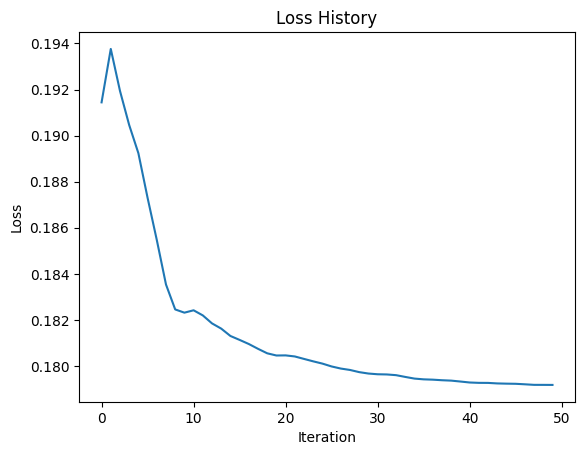

In [7]:
from sklearn.manifold import MDS


import numpy as np
import torch
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import time



def apply_custom_projection(X, n_iter=100, learning_rate=0.01):
    def torch_loss(x, t_hd_dist_mat):
        m = torch.cdist(x, x)
        return torch.mean(torch.abs(t_hd_dist_mat - torch.min(m, 1 - m)))

    N, _ = X.shape
    hd_dist_mat = distance_matrix(X, X) / 2
    t_hd_dist_mat = torch.from_numpy(hd_dist_mat)
    
    init = torch.rand(N, 1, requires_grad=True)
    
    optimizer = torch.optim.Adam([init], lr=learning_rate)
    loss_history = []

    start = time.time()

    for i in range(n_iter):
        optimizer.zero_grad()
        loss = torch_loss(init, t_hd_dist_mat)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    print(f"Final Loss: {loss.item()}")
    print(f"Optimization Time: {time.time() - start:.2f} seconds")

    d = pd.DataFrame(data=init.detach().numpy(), columns=['ori'])
    d['x'] = d['ori'].apply(lambda x: np.cos(x * 2 * np.pi))
    d['y'] = d['ori'].apply(lambda x: np.sin(x * 2 * np.pi))
    d['article_id'] = context_matrix_std.index

    return d, loss_history

def apply_2d_mds(X):
    mds = MDS(n_components=2, random_state=777)
    X_2d = mds.fit_transform(X)
    df_2d = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])
    df_2d['article_id'] = context_matrix_std.index
    return df_2d

def apply_1d_mds(X):
    mds = MDS(n_components=1, random_state=777)
    X_1d = mds.fit_transform(X)
    df_1d = pd.DataFrame(X_1d, columns=['Component 1'])
    df_1d['y'] = 0
    df_1d['article_id'] = context_matrix_std.index
    return df_1d


# Applying the projection techniques
X_mds_2d = apply_2d_mds(hd_dist_mat)
X_mds_1d = apply_1d_mds(hd_dist_mat)
X_custom, loss_history = apply_custom_projection(hd_dist_mat, n_iter=50, learning_rate=0.05)

# Plot the loss history
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Save the projection results to CSV files
X_custom.to_csv(r'C:\Users\Raphael\Projects\rbuchmueller.github.io\VAST2024\MC1\customProjection_links.csv', index=False)
X_mds_2d.to_csv(r'C:\Users\Raphael\Projects\rbuchmueller.github.io\VAST2024\MC1\mds2dProjection_links.csv', index=False)
X_mds_1d.to_csv(r'C:\Users\Raphael\Projects\rbuchmueller.github.io\VAST2024\MC1\mds1dProjection_links.csv', index=False)



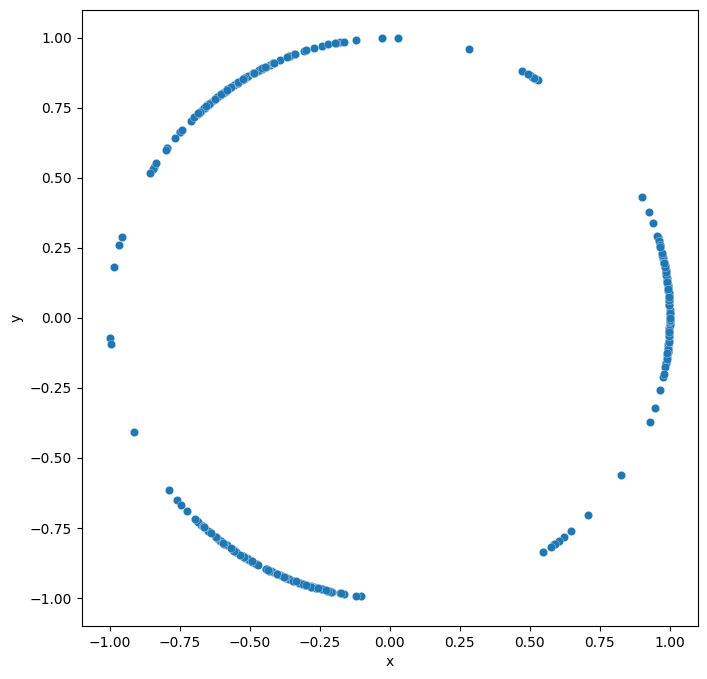

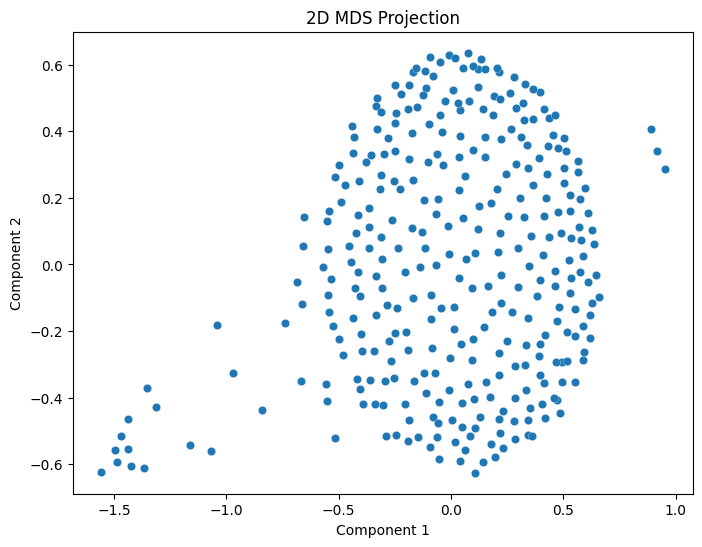

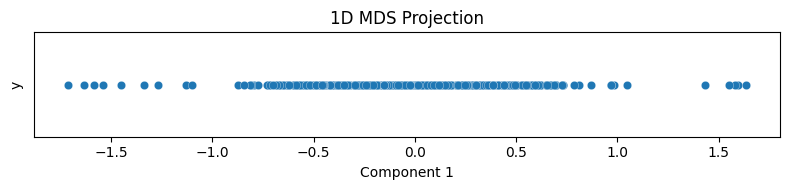

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_cPro(d):
    plt.figure(figsize=(8, 8))
    scatter = sns.scatterplot(data=d, x='x', y='y', edgecolor='white', linewidth=0.2, legend=False)

    plt.gca().set_aspect('equal', 'box')
    plt.gca().set_facecolor('white')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.show()

visualize_cPro(X_custom)

def visualize_2d_mds(X_2d):
    df_2d = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])
    df_2d['article_id'] = context_matrix_std.index

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_2d, x='Component 1', y='Component 2', edgecolor='white', linewidth=0.2)
    plt.title('2D MDS Projection')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

visualize_2d_mds(X_mds_2d)

def visualize_1d_mds(X_1d):
    df_1d = pd.DataFrame(X_1d, columns=['Component 1'])
    df_1d['y'] = 0
    df_1d['article_id'] = context_matrix_std.index

    plt.figure(figsize=(8, 2))
    sns.scatterplot(data=df_1d, x='Component 1', y='y', edgecolor='white', linewidth=0.2)
    plt.title('1D MDS Projection')
    plt.xlabel('Component 1')
    plt.yticks([])
    plt.tight_layout()
    plt.show()

visualize_1d_mds(X_mds_1d)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, euclidean_distances, pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from scipy.stats import pearsonr
from sklearn.manifold import MDS


# Apply MDS for 2D and 1D
mds_2d = MDS(n_components=2, random_state=777)
X_2d = mds_2d.fit_transform(data_std)

mds_1d = MDS(n_components=1, random_state=777)
X_1d = mds_1d.fit_transform(data_std)

# Your custom projection
custom_projection = X_custom[['x', 'y']]

# Calculate the high-dimensional distances
hd_euclidean_dist = euclidean_distances(data_std)
hd_cosine_dist = cosine_distances(data_std)
hd_manhattan_dist = manhattan_distances(data_std)

# Calculate the low-dimensional distances for each projection
ld_euclidean_dist_2d = euclidean_distances(X_2d)
ld_euclidean_dist_1d = euclidean_distances(X_1d)
ld_euclidean_dist_custom = euclidean_distances(custom_projection)

ld_cosine_dist_2d = cosine_distances(X_2d)
ld_cosine_dist_1d = cosine_distances(X_1d)
ld_cosine_dist_custom = cosine_distances(custom_projection)

ld_manhattan_dist_2d = manhattan_distances(X_2d)
ld_manhattan_dist_1d = manhattan_distances(X_1d)
ld_manhattan_dist_custom = manhattan_distances(custom_projection)

# Define your existing functions for trustworthiness, continuity, stress, and correlation here
# Function to calculate stress
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from sklearn.manifold import MDS

# Assuming data_std, df, and your projections (X_2d, X_1d, custom_projection) are already defined

# Function Definitions

def calculate_trustworthiness(X_high, X_low, n_neighbors=5, distance='euclidean'):
    if distance == 'cosine':
        X_high = cosine_distances(X_high)
        X_low = cosine_distances(X_low)
    elif distance == 'manhattan':
        X_high = manhattan_distances(X_high)
        X_low = manhattan_distances(X_low)
    
    N = X_high.shape[0]
    nn_orig = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=distance).fit(X_high)
    _, indices_orig = nn_orig.kneighbors(X_high)
    
    nn_proj = NearestNeighbors(n_neighbors=N, metric=distance).fit(X_low)
    _, indices_proj = nn_proj.kneighbors(X_low)

    rank_matrix = np.full((N, n_neighbors), N)
    for i in range(N):
        for j in range(1, n_neighbors + 1):
            if indices_orig[i, j] in indices_proj[i, 1:]:
                rank_matrix[i, j - 1] = np.where(indices_proj[i] == indices_orig[i, j])[0][0]

    rank_matrix -= (n_neighbors + 1)
    trustworthiness = 1 - (2.0 / (N * n_neighbors * (2 * N - 3 * n_neighbors - 1)) *
                           np.sum(rank_matrix[rank_matrix > n_neighbors] - n_neighbors))
    return trustworthiness

def calculate_continuity(X_high, X_low, n_neighbors=5, distance='euclidean'):
    if distance == 'euclidean':
        X_high = euclidean_distances(X_high)
        X_low = euclidean_distances(X_low)
    elif distance == 'cosine':
        X_high = cosine_distances(X_high)
        X_low = cosine_distances(X_low)
    elif distance == 'manhattan':
        X_high = manhattan_distances(X_high)
        X_low = manhattan_distances(X_low)

    N = X_high.shape[0]
    nn_low = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=distance).fit(X_low)
    _, indices_low = nn_low.kneighbors(X_low)

    nn_high = NearestNeighbors(n_neighbors=N, metric=distance).fit(X_high)
    _, indices_high = nn_high.kneighbors(X_high)

    rank_matrix = np.full((N, n_neighbors), N)
    for i in range(N):
        for j in range(1, n_neighbors + 1):
            if indices_low[i, j] in indices_high[i, 1:]:
                rank_matrix[i, j - 1] = np.where(indices_high[i] == indices_low[i, j])[0][0]

    rank_matrix -= (n_neighbors + 1)
    continuity = 1 - (2.0 / (N * n_neighbors * (2 * N - 3 * n_neighbors - 1)) *
                      np.sum(rank_matrix[rank_matrix > n_neighbors] - n_neighbors))
    return continuity

def calculate_stress(hd_distances, ld_distances):
    return np.sqrt(np.sum((hd_distances - ld_distances)**2) / np.sum(hd_distances**2))

def calculate_correlation(hd_distances, ld_distances):
    return pearsonr(hd_distances.flatten(), ld_distances.flatten())[0]

def calculate_trustworthiness(X_high, X_low, n_neighbors=5, distance='euclidean'):
    N = X_high.shape[0]
    
    # Depending on the distance metric, calculate the distances
    if distance == 'cosine':
        high_dist = cosine_distances(X_high)
        low_dist = cosine_distances(X_low)
    elif distance == 'manhattan':
        high_dist = manhattan_distances(X_high)
        low_dist = manhattan_distances(X_low)
    else:  # Euclidean
        high_dist = euclidean_distances(X_high)
        low_dist = euclidean_distances(X_low)

    # Compute nearest neighbors in the original high-dimensional space
    nn_orig = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=distance).fit(X_high)
    _, indices_orig = nn_orig.kneighbors(X_high)
    
    # Compute nearest neighbors in the low-dimensional space
    nn_proj = NearestNeighbors(n_neighbors=N, metric=distance).fit(X_low)
    _, indices_proj = nn_proj.kneighbors(X_low)

    # Calculate the rank matrix
    rank_matrix = np.full((N, n_neighbors), N)
    for i in range(N):
        for j in range(1, n_neighbors + 1):
            high_neighbor = indices_orig[i, j]
            if high_neighbor in indices_proj[i]:
                low_neighbor_rank = np.where(indices_proj[i] == high_neighbor)[0][0]
                rank_matrix[i, j - 1] = low_neighbor_rank

    # Subtract (n_neighbors + 1) from each element in the rank matrix
    rank_matrix -= (n_neighbors + 1)

    # Calculate the trustworthiness
    trustworthiness = 1 - (2.0 / (N * n_neighbors * (2 * N - 3 * n_neighbors - 1)) * 
                           np.sum(rank_matrix[rank_matrix > 0]))
    return trustworthiness

# Assuming 'data_std', 'X_transformed', 'd_1d', and 'custom_projection' are defined
# Calculating distances for Euclidean, Cosine, and Manhattan
# Function to calculate average distance (as a proxy for compactness)
def calculate_average_distance(X, distance='euclidean'):
    if distance == 'cosine':
        dist = cosine_distances(X)
    elif distance == 'manhattan':
        dist = manhattan_distances(X)
    else:  # Euclidean
        dist = euclidean_distances(X)
    return np.mean(dist)

# Calculate average distance for each projection and distance metric
avg_dist_euclidean_2d = calculate_average_distance(X_2d, distance='euclidean')
avg_dist_euclidean_1d = calculate_average_distance(X_1d, distance='euclidean')
avg_dist_euclidean_custom = calculate_average_distance(custom_projection, distance='euclidean')

avg_dist_cosine_2d = calculate_average_distance(X_2d, distance='cosine')
avg_dist_cosine_1d = calculate_average_distance(X_1d, distance='cosine')
avg_dist_cosine_custom = calculate_average_distance(custom_projection, distance='cosine')

avg_dist_manhattan_2d = calculate_average_distance(X_2d, distance='manhattan')
avg_dist_manhattan_1d = calculate_average_distance(X_1d, distance='manhattan')
avg_dist_manhattan_custom = calculate_average_distance(custom_projection, distance='manhattan')

# Euclidean distances
hd_euclidean_dist = euclidean_distances(data_std)
ld_euclidean_dist_2d = euclidean_distances(X_2d)
ld_euclidean_dist_1d = euclidean_distances(X_1d)
ld_euclidean_dist_custom = euclidean_distances(custom_projection)

# Cosine distances
hd_cosine_dist = cosine_distances(data_std)
ld_cosine_dist_2d = cosine_distances(X_2d)
ld_cosine_dist_1d = cosine_distances(X_1d)
ld_cosine_dist_custom = cosine_distances(custom_projection)

# Manhattan distances
hd_manhattan_dist = manhattan_distances(data_std)
ld_manhattan_dist_2d = manhattan_distances(X_2d)
ld_manhattan_dist_1d = manhattan_distances(X_1d)
ld_manhattan_dist_custom = manhattan_distances(custom_projection)

# Stress and correlation calculations for each metric
# Euclidean
stress_euclidean_2d = calculate_stress(hd_euclidean_dist, ld_euclidean_dist_2d)
stress_euclidean_1d = calculate_stress(hd_euclidean_dist, ld_euclidean_dist_1d)
stress_euclidean_custom = calculate_stress(hd_euclidean_dist, ld_euclidean_dist_custom)
correlation_euclidean_2d = calculate_correlation(hd_euclidean_dist, ld_euclidean_dist_2d)
correlation_euclidean_1d = calculate_correlation(hd_euclidean_dist, ld_euclidean_dist_1d)
correlation_euclidean_custom = calculate_correlation(hd_euclidean_dist, ld_euclidean_dist_custom)

# Cosine
stress_cosine_2d = calculate_stress(hd_cosine_dist, ld_cosine_dist_2d)
stress_cosine_1d = calculate_stress(hd_cosine_dist, ld_cosine_dist_1d)
stress_cosine_custom = calculate_stress(hd_cosine_dist, ld_cosine_dist_custom)
correlation_cosine_2d = calculate_correlation(hd_cosine_dist, ld_cosine_dist_2d)
correlation_cosine_1d = calculate_correlation(hd_cosine_dist, ld_cosine_dist_1d)
correlation_cosine_custom = calculate_correlation(hd_cosine_dist, ld_cosine_dist_custom)

# Manhattan
stress_manhattan_2d = calculate_stress(hd_manhattan_dist, ld_manhattan_dist_2d)
stress_manhattan_1d = calculate_stress(hd_manhattan_dist, ld_manhattan_dist_1d)
stress_manhattan_custom = calculate_stress(hd_manhattan_dist, ld_manhattan_dist_custom)
correlation_manhattan_2d = calculate_correlation(hd_manhattan_dist, ld_manhattan_dist_2d)
correlation_manhattan_1d = calculate_correlation(hd_manhattan_dist, ld_manhattan_dist_1d)
correlation_manhattan_custom = calculate_correlation(hd_manhattan_dist, ld_manhattan_dist_custom)

# Silhouette scores for each metric
silhouette_euclidean_2d = silhouette_score(X_2d, y)
silhouette_euclidean_1d = silhouette_score(X_1d, y)
silhouette_euclidean_custom = silhouette_score(custom_projection, y)

silhouette_cosine_2d = silhouette_score(X_2d, y, metric='cosine')
silhouette_cosine_1d = silhouette_score(X_1d, y, metric='cosine')
silhouette_cosine_custom = silhouette_score(custom_projection,y, metric='cosine')

silhouette_manhattan_2d = silhouette_score(X_2d,y, metric='manhattan')
silhouette_manhattan_1d = silhouette_score(X_1d, y, metric='manhattan')
silhouette_manhattan_custom = silhouette_score(custom_projection, y, metric='manhattan')


# Euclidean
trust_euclidean_2d = calculate_trustworthiness(data_std, X_2d, distance='euclidean')
trust_euclidean_1d = calculate_trustworthiness(data_std, X_1d, distance='euclidean')
trust_euclidean_custom = calculate_trustworthiness(data_std, custom_projection, distance='euclidean')

# Cosine
trust_cosine_2d = calculate_trustworthiness(data_std, X_2d, distance='cosine')
trust_cosine_1d = calculate_trustworthiness(data_std, X_1d, distance='cosine')
trust_cosine_custom = calculate_trustworthiness(data_std, custom_projection, distance='cosine')

# Manhattan
trust_manhattan_2d = calculate_trustworthiness(data_std, X_2d, distance='manhattan')
trust_manhattan_1d = calculate_trustworthiness(data_std, X_1d, distance='manhattan')
trust_manhattan_custom = calculate_trustworthiness(data_std, custom_projection, distance='manhattan')
# Your code to display or analyze the calculated metrics goes here

print("2D MDS Metrics:")
print(f"  Euclidean - Stress: {stress_euclidean_2d}, Correlation: {correlation_euclidean_2d}, Silhouette: {silhouette_euclidean_2d}, Trustworthiness: {trust_euclidean_2d}, Avg Dist: {avg_dist_euclidean_2d}")
print(f"  Cosine - Stress: {stress_cosine_2d}, Correlation: {correlation_cosine_2d}, Silhouette: {silhouette_cosine_2d}, Trustworthiness: {trust_cosine_2d}, Avg Dist: {avg_dist_cosine_2d}")
print(f"  Manhattan - Stress: {stress_manhattan_2d}, Correlation: {correlation_manhattan_2d}, Silhouette: {silhouette_manhattan_2d}, Trustworthiness: {trust_manhattan_2d}, Avg Dist: {avg_dist_manhattan_2d}")
print("\n")

print("1D MDS Metrics:")
print(f"  Euclidean - Stress: {stress_euclidean_1d}, Correlation: {correlation_euclidean_1d}, Silhouette: {silhouette_euclidean_1d}, Trustworthiness: {trust_euclidean_1d}, Avg Dist: {avg_dist_euclidean_1d}")
print(f"  Cosine - Stress: {stress_cosine_1d}, Correlation: {correlation_cosine_1d}, Silhouette: {silhouette_cosine_1d}, Trustworthiness: {trust_cosine_1d}, Avg Dist: {avg_dist_cosine_1d}")
print(f"  Manhattan - Stress: {stress_manhattan_1d}, Correlation: {correlation_manhattan_1d}, Silhouette: {silhouette_manhattan_1d}, Trustworthiness: {trust_manhattan_1d}, Avg Dist: {avg_dist_manhattan_1d}")
print("\n")

print("Custom Projection Metrics:")
print(f"  Euclidean - Stress: {stress_euclidean_custom}, Correlation: {correlation_euclidean_custom}, Silhouette: {silhouette_euclidean_custom}, Trustworthiness: {trust_euclidean_custom}, Avg Dist: {avg_dist_euclidean_custom}")
print(f"  Cosine - Stress: {stress_cosine_custom}, Correlation: {correlation_cosine_custom}, Silhouette: {silhouette_cosine_custom}, Trustworthiness: {trust_cosine_custom}, Avg Dist: {avg_dist_cosine_custom}")
print(f"  Manhattan - Stress: {stress_manhattan_custom}, Correlation: {correlation_manhattan_custom}, Silhouette: {silhouette_manhattan_custom}, Trustworthiness: {trust_manhattan_custom}, Avg Dist: {avg_dist_manhattan_custom}")
print("\n")


c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (150,150) (338,338) 